In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator, lp_by_lf

In [2]:
FILE_PATH = "../dataset/imu.txt"
gyro_accel_data = pd.read_csv(FILE_PATH,sep=" ")
gyro_accel_data 

,#,timestamp,ang_vel_x,ang_vel_y,ang_vel_z,lin_acc_x,lin_acc_y,lin_acc_z
0,0,4878.790299,-0.004261,-0.001065,-0.009587,-0.033519,-0.158017,9.797023
1,1,4878.792303,-0.007457,-0.005326,-0.005326,-0.052672,-0.134075,9.777869
2,2,4878.794301,-0.006392,-0.007457,-0.002131,-0.081402,-0.138863,9.715620
3,3,4878.796302,-0.005326,-0.007457,-0.005326,-0.076614,-0.143651,9.715620
4,4,4878.798302,-0.003196,-0.006392,-0.005326,-0.100556,-0.177170,9.658160
...,...,...,...,...,...,...,...,...
46048,46048,4970.886300,-0.002131,-0.001065,-0.004261,-0.014365,-0.244207,9.773081
46049,46049,4970.888300,-0.003196,-0.001065,-0.003196,-0.014365,-0.234631,9.792234
46050,46050,4970.890298,-0.002131,-0.001065,-0.003196,0.000000,-0.220265,9.777869
46051,46051,4970.892300,-0.005326,-0.001065,-0.005326,-0.043095,-0.220265,9.777869


In [ ]:
import numpy as np

def _create_spectrogram(signal: np.ndarray) -> np.ndarray:
    n = len(signal)  # Length of the signal
    sigma = 3
    time_list = np.arange(n)
    spectrogram = np.zeros((n, n))

    for (i, time) in enumerate(time_list):
        g = _get_gaussian_filter(time, time_list, sigma)
        ug = signal * g       
        ugt = np.abs(np.fft.fftshift(np.fft.fft(ug)))        
        spectrogram[:, i] = ugt

    return spectrogram

def _get_gaussian_filter(b: float, b_list: np.ndarray,
                         sigma: float) -> np.ndarray:
   
    a = 1 / (2 * sigma**2)
    return np.exp(-a * (b_list - b)**2)


accelerometer_data_x = gyro_accel_data['ang_vel_x']


spectrogram = _create_spectrogram(accelerometer_data_x)


plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram of Accelerometer Data (x-axis)')
plt.colorbar(label='Amplitude')
plt.show()

In [3]:
def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

freq:  250 chosen_bias:  [-12.937 -23.531 -24.356 -24.554] chosen_weights:  [70.194 44.39  47.087 48.558 49.006]


<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


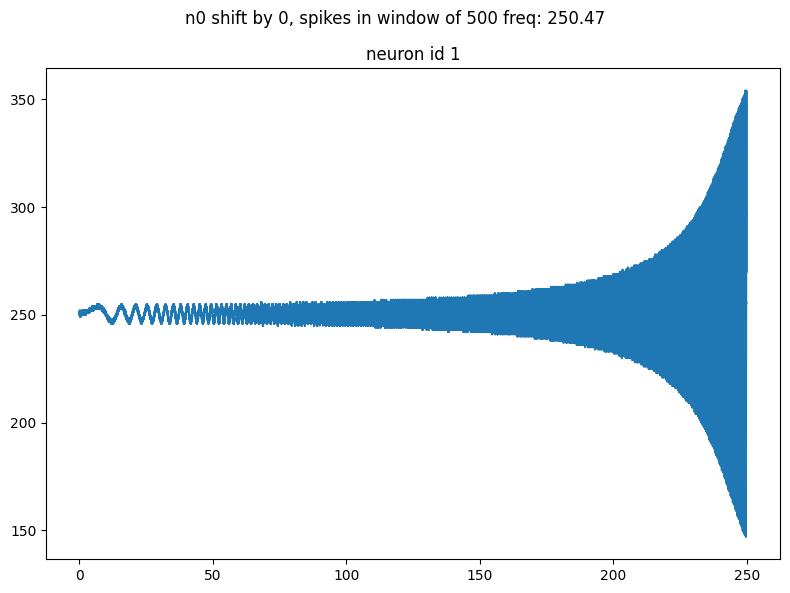

freq:  220 chosen_bias:  [-10.36  -20.593 -21.075 -21.41 ] chosen_weights:  [61.729 40.966 41.282 42.017 42.751]


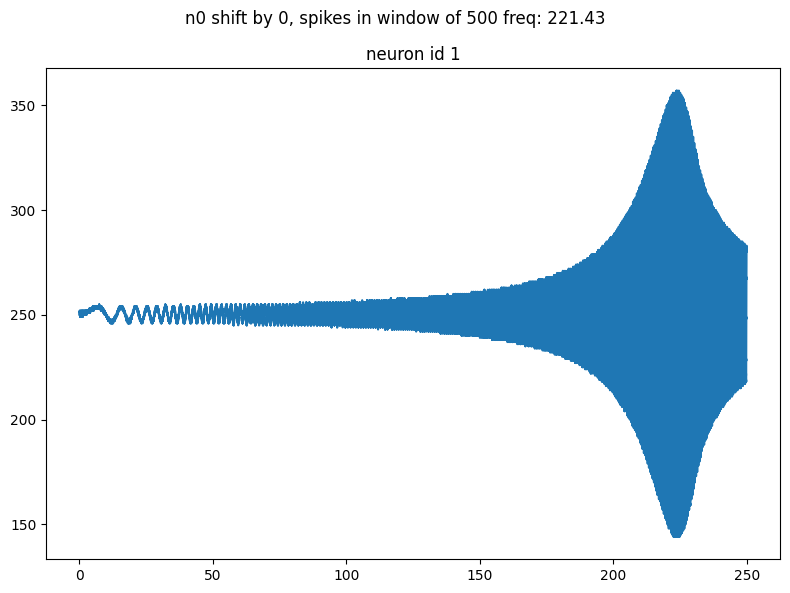

freq:  210 chosen_bias:  [-12.287 -21.35  -21.922 -21.913] chosen_weights:  [56.389 32.463 42.702 43.734 43.7  ]


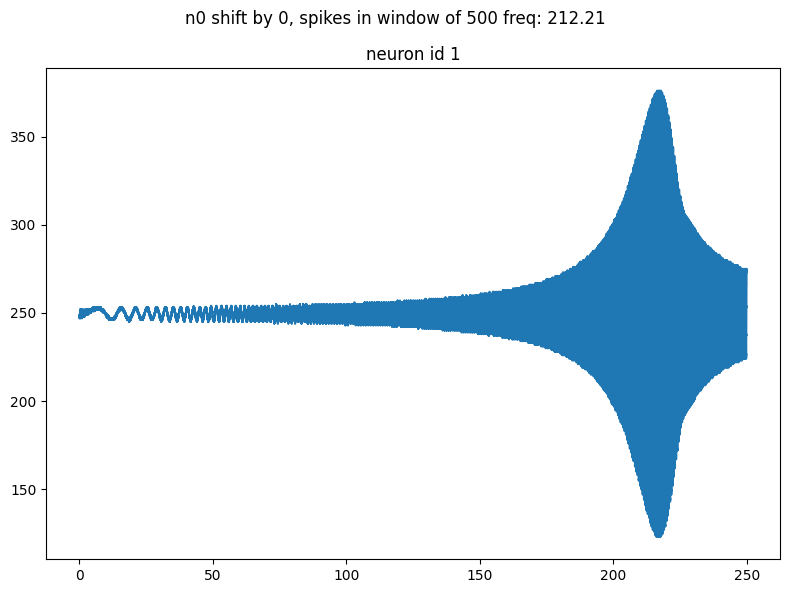

freq:  190 chosen_bias:  [ -8.972 -17.668 -18.54  -19.15 ] chosen_weights:  [51.585 33.682 35.487 36.9   38.183]


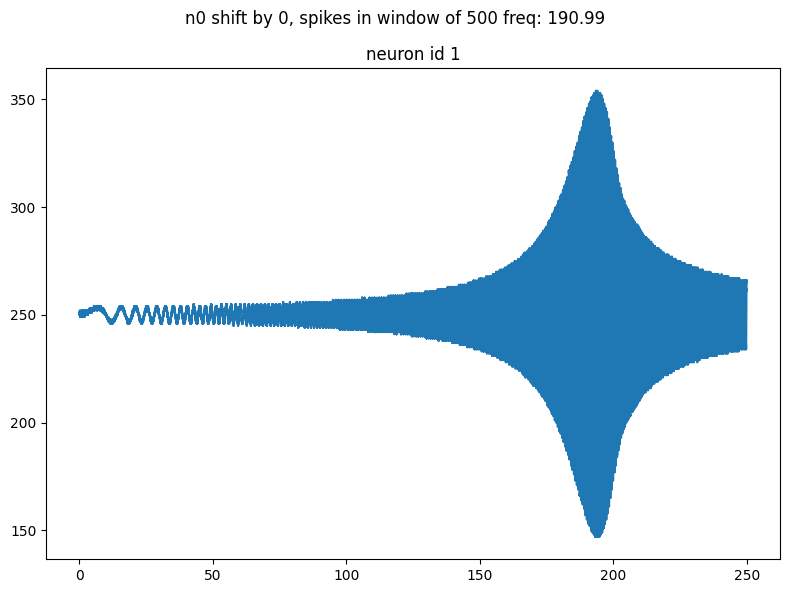

freq:  170 chosen_bias:  [ -7.992 -16.158 -16.876 -17.57 ] chosen_weights:  [44.591 28.723 32.551 33.553 35.006]


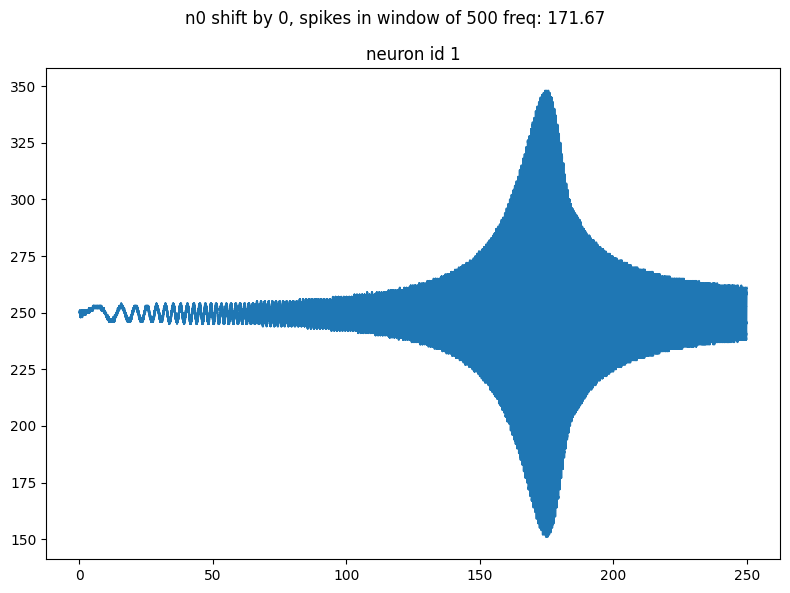

freq:  150 chosen_bias:  [ -6.44  -14.375 -14.949 -15.689] chosen_weights:  [37.199 24.648 29.019 29.769 31.354]


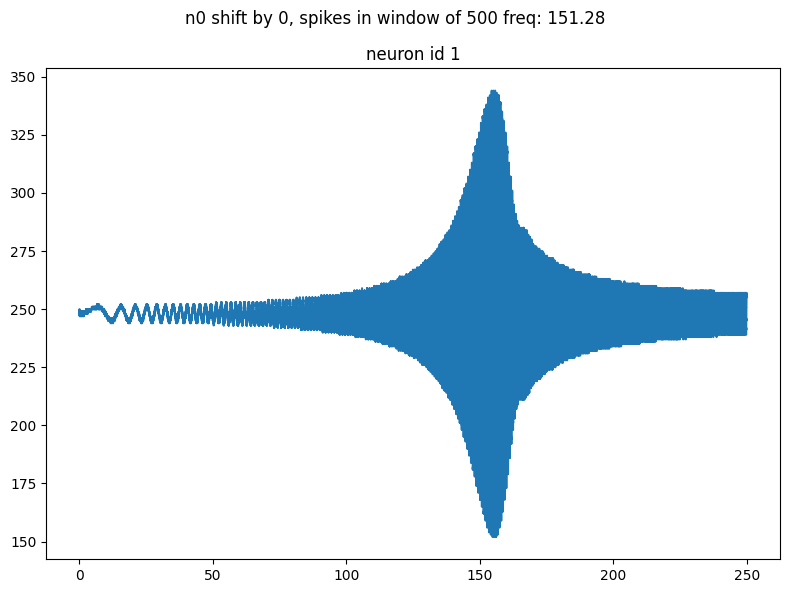

freq:  130 chosen_bias:  [ -5.519 -13.013 -12.731 -12.629] chosen_weights:  [32.205 21.629 26.389 25.421 25.393]


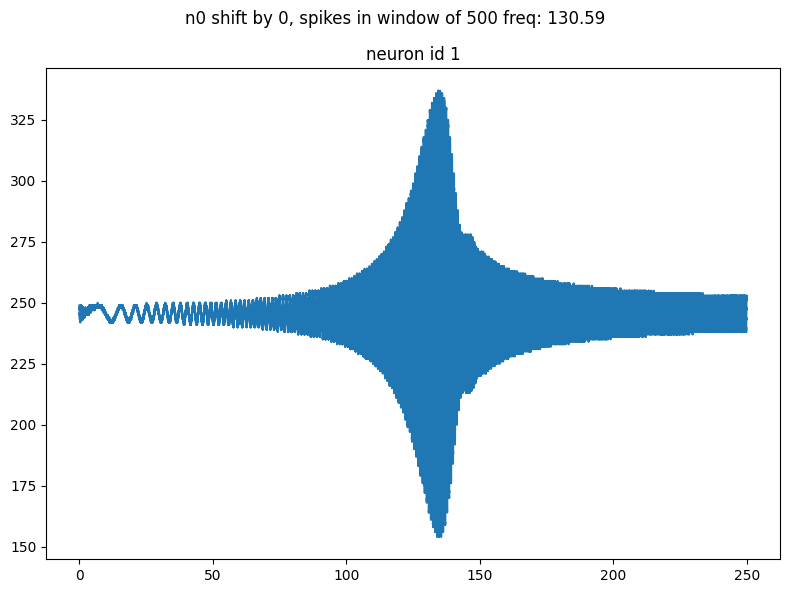

freq:  90 chosen_bias:  [-2.113 -8.982 -8.803 -8.984] chosen_weights:  [19.572 15.247 17.858 17.907 17.915]


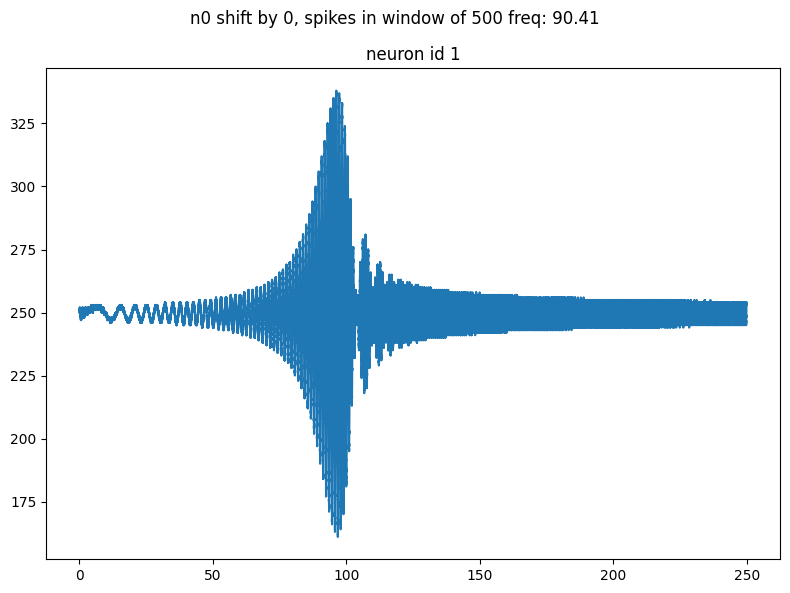

freq:  50 chosen_bias:  [-0.546 -4.029 -4.439 -5.114] chosen_weights:  [12.41  10.444  8.104  9.106 10.255]


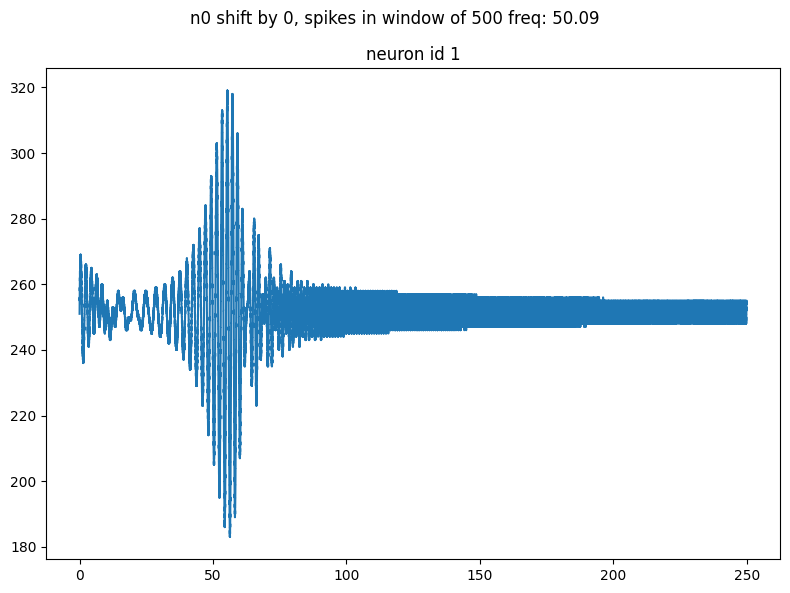

In [4]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
import numpy as np
import matplotlib.pyplot as plt

chosen_bias = {250:np.array([-12.937, -23.531, -24.356, -24.554 ]),
               220:np.array([-10.36,-20.593,-21.075,-21.41]),
               210:np.array([-12.287,-21.35,-21.922,-21.913]),
               190:np.array([-8.972,-17.668,-18.54,-19.15]),
               170:np.array([-7.992,-16.158,-16.876,-17.57]),
               150:np.array([-6.44,-14.375,-14.949,-15.689]),
               130:np.array([-5.519, -13.013, -12.731,-12.629]),
               90:np.array([-2.113,-8.982,-8.803,-8.984]),
               50:np.array([-0.546,-4.029,-4.439,-5.114])
               }


chosen_weights = {250:np.array([70.194,44.39, 47.087, 48.558, 49.006 ]),
                  220:np.array([61.729,40.966,41.282,42.017,42.751]),
                  210:np.array([56.389, 32.463, 42.702, 43.734, 43.7]),
                  190:np.array([51.585,33.682,35.487,36.9,38.183]),
                  170:np.array([44.591,28.723,32.551,33.553,35.006]),
                  150:np.array([37.199,24.648,29.019,29.769,31.354]),
                  130:np.array([32.205,21.629,26.389,25.421,25.393]),
                  90:np.array([19.572,15.247,17.858,17.907,17.915]),
                  50:np.array([12.41,10.444,8.104,9.106,10.255])
                  }

chosen_frequencies = [250,220,210,190,170,150,130,90,50]
y_spikes_results =[]
for freq0 in chosen_frequencies:
    print("freq: ", freq0, "chosen_bias: ", chosen_bias[freq0], "chosen_weights: ", chosen_weights[freq0])
    spikes_list = []
    spikes_array=[]
    y_spikes=[]
    clk_freq = 1536000
    lf=4
    spikes_window = 500
    phase_shifts = [0] + [45]*3
    
    phase_shifts = np.cumsum(phase_shifts)
    res_resonator = simple_resonator(
        clk_freq=clk_freq,
        freq0=freq0,
        lf=lf,
        thetas=chosen_bias[freq0],
        weights=chosen_weights[freq0],
    )
    
    for nid in range(1, 5):
        res_resonator.log_out_spikes(nid)
    
    start_freq = 0
    spectrum = 250
    res_resonator.forget_logs()
    
    step = 100/clk_freq
    test_size = int(spectrum / step)
    test_resonator_on_chirp(
        res_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )
    snr = [0] * 4
    peak = [0] * 4
    best_lp = lp_by_lf(lf, freq0, clk_freq)
    f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
    
    # Selecting which neuron to plot (change nid accordingly)
    nid = 0
    
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
    
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
    y_spikes_results.append(y_spikes)
    # Plotting the spikes
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid + 1}')
    
    plt.tight_layout()
    plt.show()




In [5]:
y_spikes_results

[array([250., 250., 250., ..., 272., 271., 270.]),
 array([250., 251., 250., ..., 282., 282., 282.]),
 array([249., 249., 249., ..., 274., 274., 274.]),
 array([250., 250., 250., ..., 265., 266., 266.]),
 array([250., 250., 250., ..., 261., 260., 261.]),
 array([249., 250., 249., ..., 256., 257., 256.]),
 array([249., 249., 249., ..., 252., 253., 252.]),
 array([250., 250., 250., ..., 253., 254., 253.]),
 array([251., 252., 251., ..., 254., 255., 254.])]

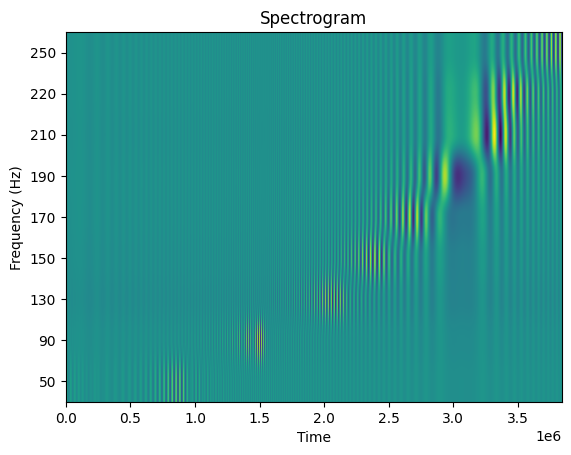

In [6]:


# Convert the list of arrays to NumPy arrays
list_spikes = [np.array(arr) for arr in y_spikes_results]

# Find the maximum length of arrays in the list
max_length = max(arr.size for arr in list_spikes)

# Pad arrays with smaller lengths with zeros
for i in range(len(list_spikes)):
    if list_spikes[i].size < max_length:
        padding_length = max_length - list_spikes[i].size
        list_spikes[i] = np.pad(list_spikes[i], (0, padding_length), 'constant', constant_values=(0))

# Combine arrays into a single array
combined_array = np.vstack(list_spikes)

# Define frequencies and y-axis ticks   
frequencies = [250, 220, 210, 190, 170, 150, 130, 90, 50]
y_ticks = np.arange(len(frequencies))

# Plot the combined array
plt.imshow(combined_array, aspect='auto')
# plt.colorbar(label='Intensity')  # Add a colorbar label
plt.title('Spectrogram')  # Add a title
plt.xlabel('Time')  # Add x-axis label if needed
plt.yticks(y_ticks, frequencies)  # Set y-axis ticks to frequencies
plt.ylabel('Frequency (Hz)')  # Add y-axis label
plt.show()

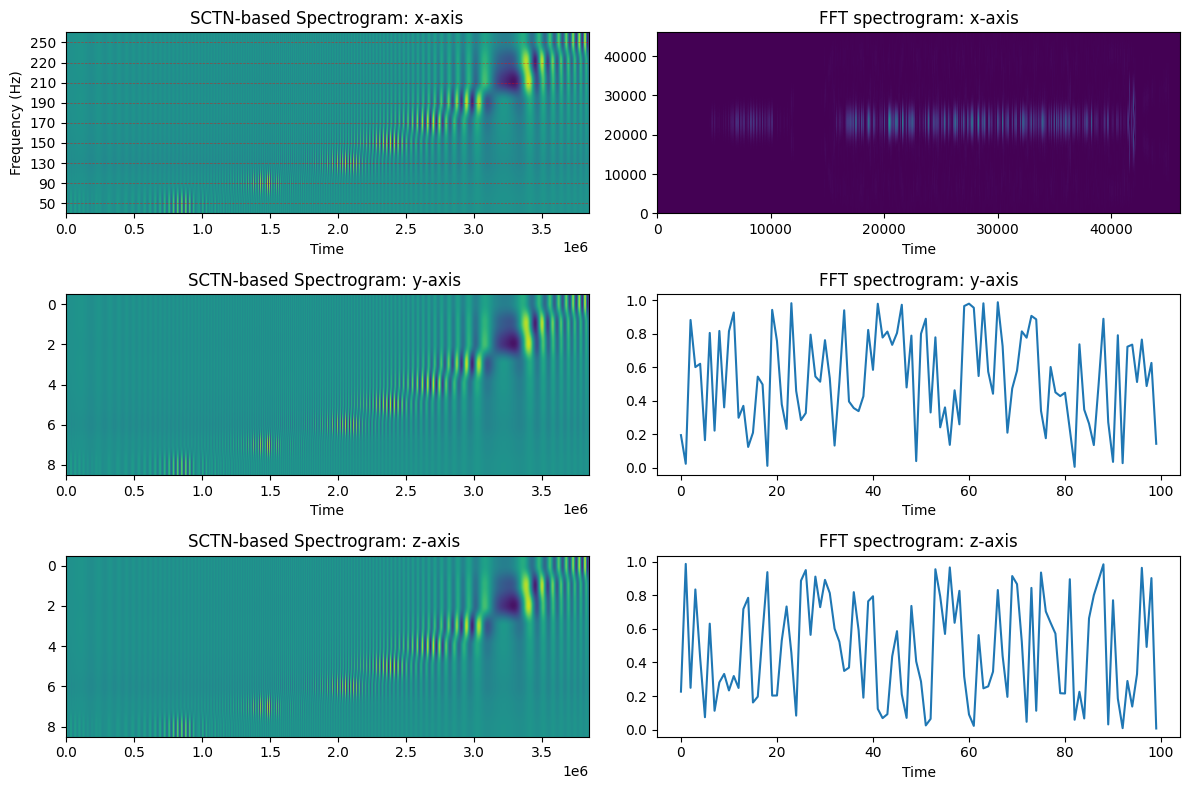

In [7]:
import numpy as np
import matplotlib.pyplot as plt



def _create_spectrogram(signal: np.ndarray) -> np.ndarray:
    n = len(signal)  # Length of the signal
    sigma = 3
    time_list = np.arange(n)
    spectrogram = np.zeros((n, n))

    for (i, time) in enumerate(time_list):
        g = _get_gaussian_filter(time, time_list, sigma)
        ug = signal * g       
        ugt = np.abs(np.fft.fftshift(np.fft.fft(ug)))        
        spectrogram[:, i] = ugt

    return spectrogram

def _get_gaussian_filter(b: float, b_list: np.ndarray,
                         sigma: float) -> np.ndarray:
   
    a = 1 / (2 * sigma**2)
    return np.exp(-a * (b_list - b)**2)

# Convert the list of arrays to NumPy arrays
list_spikes = [np.array(arr) for arr in y_spikes_results]
# Find the maximum length of arrays in the list
max_length = max(arr.size for arr in list_spikes)
# Combine arrays into a single array
combined_array = np.vstack(list_spikes)

# Define frequencies and y-axis ticks   
frequencies = [250, 220, 210, 190, 170, 150, 130, 90, 50]
y_ticks = np.arange(len(frequencies))

# Create a subplot grid with 1 row and 2 columns
fig, axe = plt.subplots(3, 2, figsize=(12, 8))


axes = axe.flatten()
data2 = np.random.rand(100)
data3 = np.random.rand(100)
data4 = np.random.rand(100)
data5 = np.random.rand(100)
data6 = np.random.rand(100)
i=0

# Plot data on each subplot
axes[0].imshow(combined_array, aspect='auto')
axes[0].set_title('SCTN-based Spectrogram: x-axis')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency (Hz)')
# Set y-axis ticks and labels for the first subplot
axes[0].set_yticks(y_ticks)
axes[0].set_yticklabels(frequencies)
# Add dashed lines for frequencies to the first subplot
for freq in frequencies:
    axes[0].axhline(y=i, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    i+=1
  

accelerometer_data_x = gyro_accel_data['ang_vel_x']
spectrogram = _create_spectrogram(accelerometer_data_x)
axes[1].imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('FFT spectrogram: x-axis')
axes[1].set_xlabel('Time')


axes[2].imshow(combined_array, aspect='auto')
axes[2].set_title('SCTN-based Spectrogram: y-axis ')
axes[2].set_xlabel('Time')

axes[3].plot(data4)
axes[3].set_title('FFT spectrogram: y-axis')
axes[3].set_xlabel('Time')

axes[4].imshow(combined_array, aspect='auto')
axes[4].set_title('SCTN-based Spectrogram: z-axis ')
axes[5].set_xlabel('Time')

axes[5].plot(data6)
axes[5].set_title('FFT spectrogram: z-axis')
axes[5].set_xlabel('Time')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


